## - Import

In [194]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [195]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.1.1
device: cpu


## - Parameters and Data

In [196]:
label_mapping_df = pd.read_csv('album_label_map.csv')

# Create a list where the index corresponds to the numerical label
class_list = label_mapping_df.sort_values('label')['label_name'].tolist()
print(class_list)

class_num = len(class_list)

['pop', 'metal', 'indie', 'other', 'reggae', 'electronic', 'classical', 'r&b', 'rock', 'dance', 'folk', 'hiphop', 'country', 'funk']


In [197]:
# Data
train_data_path = './output.csv' # Path of data
#valid_data_path = './data/Fashion MNIST/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
#print('Valid data path:', valid_data_path)

img_size = 64 # Image size
batch_size = 32  # Batch size

# Model
z_size = class_num * class_num
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 2e-4

Train data path: ./output.csv


## - Pytorch Dataset, DataLoader: Fashion MNIST

In [198]:
class AlbumCovers(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [199]:
dataset = AlbumCovers(train_data_path, img_size)

Image size: (30291, 64, 64)
--- Label ---
label
0     6032
8     5996
3     4860
11    3685
5     2570
9     2380
2     1556
7     1088
10     730
1      445
12     374
6      296
13     187
4       92
Name: count, dtype: int64


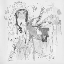

In [200]:
dataset[1][0]

In [201]:
class_list[dataset[1][1]]

'pop'

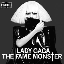

In [202]:
dataset[10][0]

In [203]:
class_list[dataset[10][1]]

'pop'

In [204]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [205]:
dataset = AlbumCovers(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Image size: (30291, 64, 64)
--- Label ---
label
0     6032
8     5996
3     4860
11    3685
5     2570
9     2380
2     1556
7     1088
10     730
1      445
12     374
6      296
13     187
4       92
Name: count, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


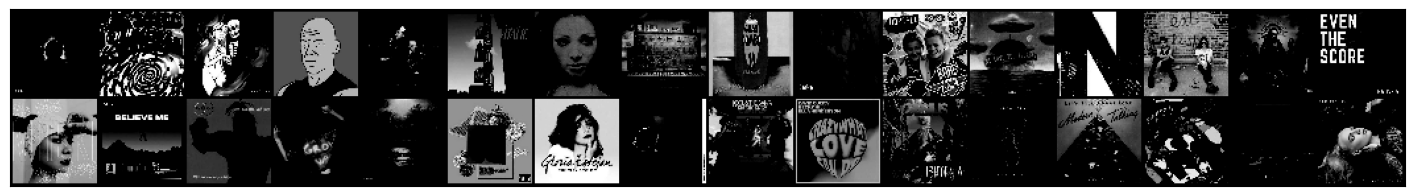

In [208]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

## - Generator

In [209]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [210]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [211]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [212]:
# Loss function
criterion = nn.BCELoss()

In [213]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [214]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [215]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 1.9649465084075928, d_loss: 0.613670825958252


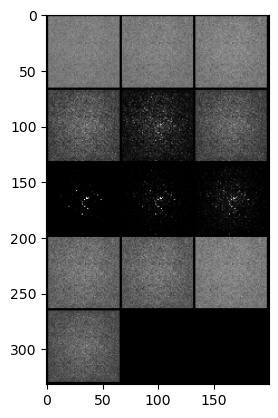

Starting epoch 2...
g_loss: 3.1976723670959473, d_loss: 0.9491064548492432


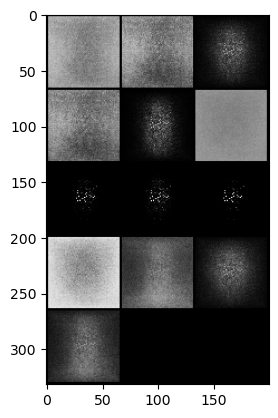

Starting epoch 3...
g_loss: 1.9829280376434326, d_loss: 0.7650500535964966


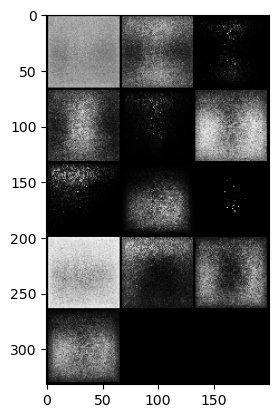

Starting epoch 4...
g_loss: 2.4670913219451904, d_loss: 0.7204062342643738


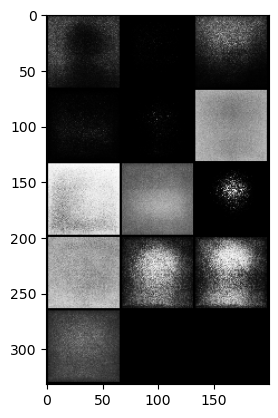

Starting epoch 5...
g_loss: 1.7052682638168335, d_loss: 0.7658265829086304


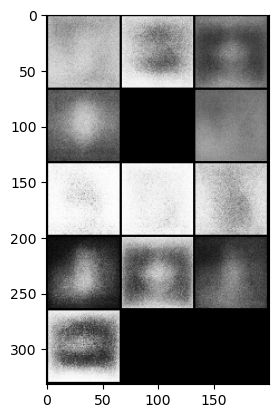

Starting epoch 6...
g_loss: 1.7601921558380127, d_loss: 0.7014166116714478


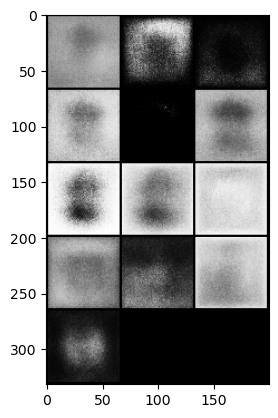

Starting epoch 7...
g_loss: 1.8576037883758545, d_loss: 0.9164590835571289


Starting epoch 8...
g_loss: 1.0902557373046875, d_loss: 0.9129089117050171


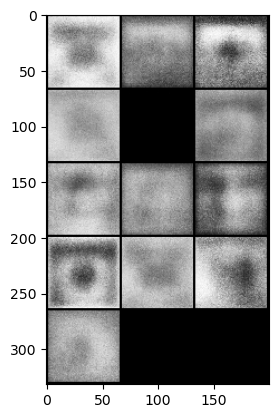

Starting epoch 9...
g_loss: 1.175959825515747, d_loss: 1.08143150806427


Starting epoch 10...
g_loss: 1.2754020690917969, d_loss: 0.9481518268585205


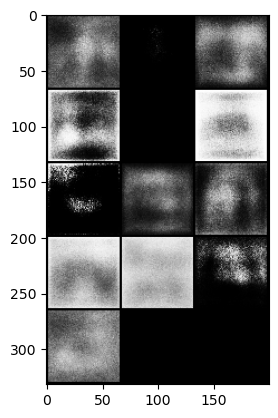

Starting epoch 11...
g_loss: 1.3752079010009766, d_loss: 1.138159990310669


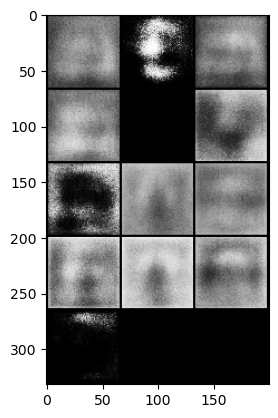

Starting epoch 12...
g_loss: 1.1108952760696411, d_loss: 0.9578755497932434


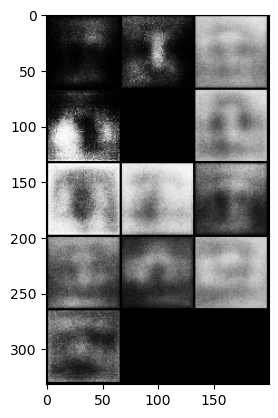

Starting epoch 13...
g_loss: 1.712752342224121, d_loss: 0.729435920715332


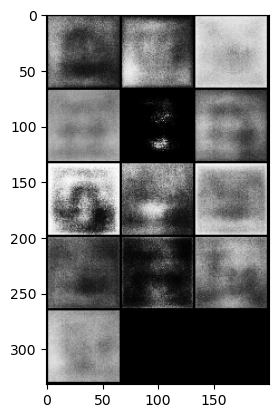

Starting epoch 14...
g_loss: 2.2636053562164307, d_loss: 0.781621515750885


Starting epoch 15...
g_loss: 1.1433303356170654, d_loss: 0.9170749187469482


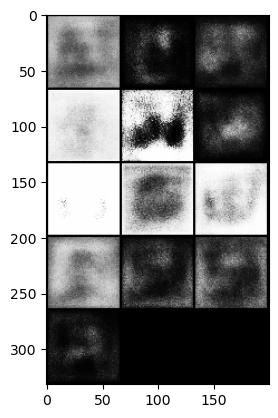

Starting epoch 16...
g_loss: 1.3607536554336548, d_loss: 1.0020040273666382


Starting epoch 17...
g_loss: 1.7201745510101318, d_loss: 0.9998408555984497


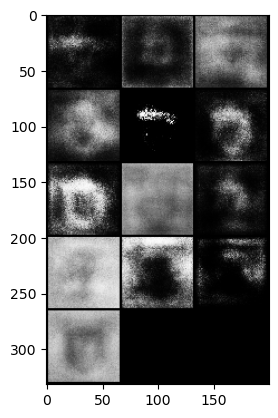

Starting epoch 18...
g_loss: 1.0924807786941528, d_loss: 1.0018408298492432


Starting epoch 19...
g_loss: 1.5428467988967896, d_loss: 1.0975499153137207


Starting epoch 20...
g_loss: 1.4265366792678833, d_loss: 0.8124016523361206


Starting epoch 21...
g_loss: 1.3259013891220093, d_loss: 1.275263786315918


Starting epoch 22...
g_loss: 1.4692151546478271, d_loss: 0.955215573310852


Starting epoch 23...
g_loss: 1.6023633480072021, d_loss: 1.0629130601882935


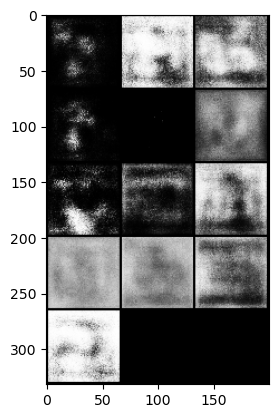

Starting epoch 24...
g_loss: 1.0806760787963867, d_loss: 1.0785692930221558


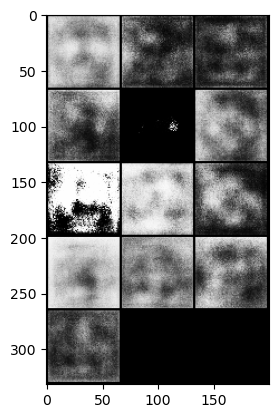

Starting epoch 25...
g_loss: 1.8715157508850098, d_loss: 0.9269360303878784


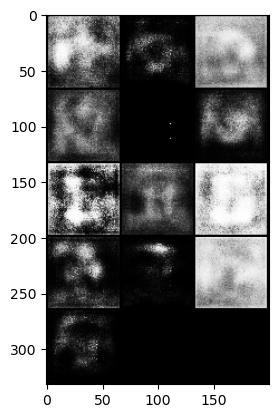

Starting epoch 26...
g_loss: 1.6847355365753174, d_loss: 1.0472921133041382


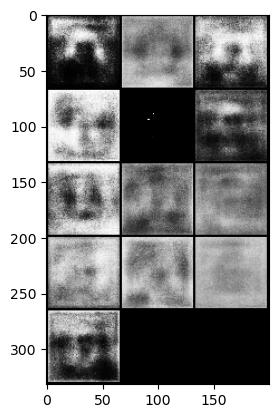

Starting epoch 27...
g_loss: 1.7889589071273804, d_loss: 0.7290220856666565


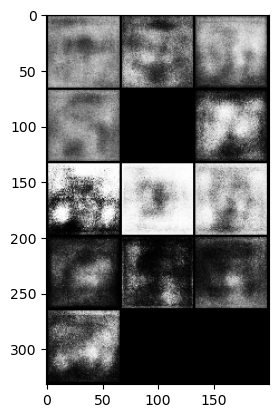

Starting epoch 28...
g_loss: 1.7295303344726562, d_loss: 1.0635030269622803


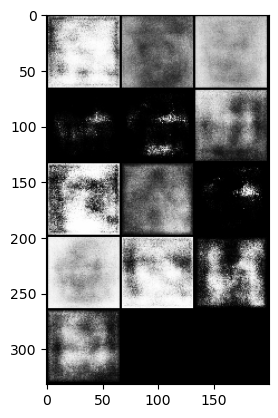

Starting epoch 29...
g_loss: 1.3988069295883179, d_loss: 1.022558569908142


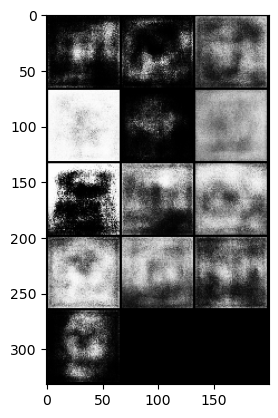

Starting epoch 30...
g_loss: 1.2998214960098267, d_loss: 1.3798590898513794


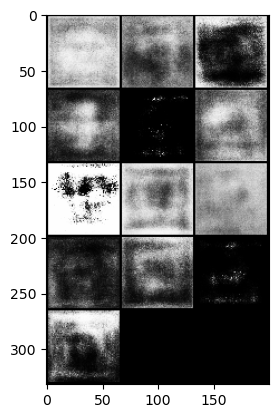

In [216]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(data_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## - Show Generating Images

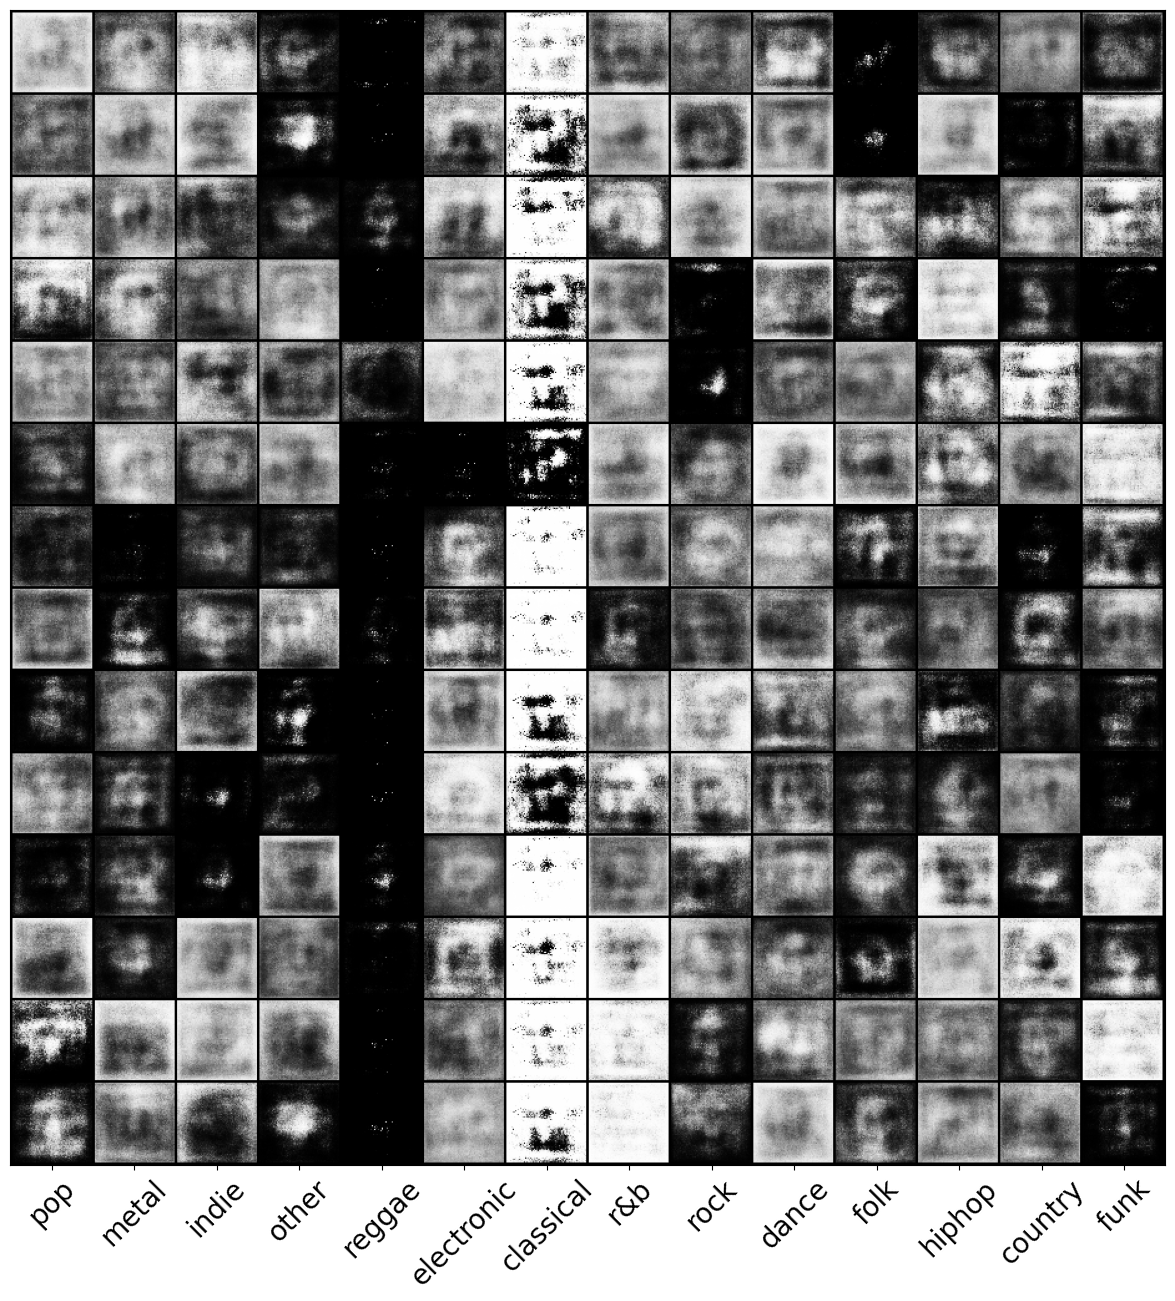

In [217]:
batch_size_generation = class_num * 10

# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 13
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Building z 
#z = Variable(torch.randn(batch_size_generation, z_size)).to(device)

# Labels 0 ~ 13
#labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size_generation))).to(device)

# Generating images
#print(z.shape, labels.shape)
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1, 2, 0).numpy()
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(grid)

# Adjust ticks to be at the center of each column
column_positions = np.arange(class_num) * (grid.shape[1] / class_num) + (grid.shape[1] / class_num) / 2
_ = plt.yticks([])
_ = plt.xticks(column_positions, class_list, rotation=45, fontsize=20, ha='center')
